In [33]:
# Dependencies
import pandas as pd
from pathlib import Path
from dateutil import parser
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [34]:
# Store filepath in a variable
file_one = Path("Resources\historical-property-sales-data-June11.csv")

In [35]:
# Read our data file with the Pandas library
# Not every CSV requires an encoding, but be aware this can come up
properties_original_df = pd.read_csv(file_one, encoding="ISO-8859-1")
properties_original_df.head()

,ï»¿PropertyID,PropType,taxkey,Address,CondoProject,District,nbhd,Style,Extwall,Stories,Year_Built,Rooms,FinishedSqft,Lotsize,Units,Bdrms,Fbath,Hbath,Sale_date,Sale_price
0,862416.0,Commercial,5370701000,115 W OKLAHOMA AV,NaN,14.0,6440.0,Fast Food Operation,Alum/Vynyl Siding,1.0,2000.0,NaN,"3,229","1,703,065,320",1,NaN,0.0,0.0,12/23/2020,"$2,150,000"
1,862062.0,Commercial,6269997114,151 W LAYTON AV,NaN,13.0,6440.0,Fast Food Operation,Concrete Block,1.0,1968.0,NaN,"1,980","457,380,000",1,NaN,0.0,0.0,12/23/2020,"$1,200,000"
2,870290.0,Commercial,330432000,9050-9100 N SWAN RD,NaN,9.0,6202.0,Day Care Center,NaN,1.0,2000.0,NaN,"34,100","2,238,984",1,NaN,0.0,0.0,5/7/2021,"$1,500,000"
3,NaN,Residential,1120031000,7244 N BEAU AV,NaN,5.0,820.0,**,NaN,0.0,0.0,0.0,0,10000,0,0.0,0.0,0.0,2018-04-01,356700
4,NaN,Vacant Land,369999400,9201R N 107TH ST,NaN,9.0,6411.0,Commercial Land,NaN,0.0,0.0,0.0,0,1090307,1,0.0,0.0,0.0,2015-11-01,790000


In [36]:
properties_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56048 entries, 0 to 56047
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ï»¿PropertyID  32048 non-null  float64
 1   PropType       56040 non-null  object 
 2   taxkey         56048 non-null  int64  
 3   Address        56044 non-null  object 
 4   CondoProject   9142 non-null   object 
 5   District       56046 non-null  float64
 6   nbhd           55991 non-null  float64
 7   Style          55957 non-null  object 
 8   Extwall        45621 non-null  object 
 9   Stories        55879 non-null  float64
 10  Year_Built     55987 non-null  float64
 11  Rooms          54418 non-null  float64
 12  FinishedSqft   55947 non-null  object 
 13  Lotsize        56048 non-null  object 
 14  Units          56048 non-null  int64  
 15  Bdrms          54419 non-null  float64
 16  Fbath          55393 non-null  float64
 17  Hbath          51208 non-null  float64
 18  Sale_d

In [37]:
#getting only 'Residential' values
residential_properties_df = properties_original_df.loc[properties_original_df["PropType"] == 'Residential']
residential_properties_df = residential_properties_df.drop(columns=['CondoProject', 'ï»¿PropertyID','PropType','District','nbhd','Stories','taxkey','Rooms','Year_Built','Units'], axis=1)
residential_properties_df.isnull().sum()

Address            3
Style             87
Extwall          100
FinishedSqft      90
Lotsize            0
Bdrms            128
Fbath             10
Hbath           3610
Sale_date          0
Sale_price         8
dtype: int64

In [38]:
filtered_residential_properties_df = residential_properties_df.copy()

Trying the data out without filtering out the styles, but instead filtering on bedrooms and price ranges later on

In [39]:
#check datatype of each column
filtered_residential_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43638 entries, 3 to 56003
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Address       43635 non-null  object 
 1   Style         43551 non-null  object 
 2   Extwall       43538 non-null  object 
 3   FinishedSqft  43548 non-null  object 
 4   Lotsize       43638 non-null  object 
 5   Bdrms         43510 non-null  float64
 6   Fbath         43628 non-null  float64
 7   Hbath         40028 non-null  float64
 8   Sale_date     43638 non-null  object 
 9   Sale_price    43630 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.7+ MB


In [40]:
filtered_residential_properties_df['Baths_total'] = filtered_residential_properties_df['Fbath'] + filtered_residential_properties_df['Hbath']
filtered_residential_properties_df = filtered_residential_properties_df.drop(columns=['Fbath','Hbath'], axis=1)
filtered_residential_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43638 entries, 3 to 56003
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Address       43635 non-null  object 
 1   Style         43551 non-null  object 
 2   Extwall       43538 non-null  object 
 3   FinishedSqft  43548 non-null  object 
 4   Lotsize       43638 non-null  object 
 5   Bdrms         43510 non-null  float64
 6   Sale_date     43638 non-null  object 
 7   Sale_price    43630 non-null  object 
 8   Baths_total   40023 non-null  float64
dtypes: float64(2), object(7)
memory usage: 3.3+ MB


In [41]:
filtered_residential_properties_df['Sale_date'] = pd.to_datetime(filtered_residential_properties_df['Sale_date'], infer_datetime_format=True, format='mixed')
filtered_residential_properties_df['Sale_year'] = filtered_residential_properties_df['Sale_date'].dt.year
filtered_residential_properties_df['Sale_month'] = filtered_residential_properties_df['Sale_date'].dt.month
filtered_residential_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43638 entries, 3 to 56003
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Address       43635 non-null  object        
 1   Style         43551 non-null  object        
 2   Extwall       43538 non-null  object        
 3   FinishedSqft  43548 non-null  object        
 4   Lotsize       43638 non-null  object        
 5   Bdrms         43510 non-null  float64       
 6   Sale_date     43638 non-null  datetime64[ns]
 7   Sale_price    43630 non-null  object        
 8   Baths_total   40023 non-null  float64       
 9   Sale_year     43638 non-null  int32         
 10  Sale_month    43638 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), object(6)
memory usage: 3.7+ MB


C:\Users\Ajunjee Selvam\AppData\Local\Temp\ipykernel_26184\1218348728.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  filtered_residential_properties_df['Sale_date'] = pd.to_datetime(filtered_residential_properties_df['Sale_date'], infer_datetime_format=True, format='mixed')


In [42]:
filtered_residential_properties_df=filtered_residential_properties_df.dropna(subset=['Address','Extwall','Bdrms','Baths_total','Sale_price'])
filtered_residential_properties_df.isnull().sum()

Address         0
Style           0
Extwall         0
FinishedSqft    0
Lotsize         0
Bdrms           0
Sale_date       0
Sale_price      0
Baths_total     0
Sale_year       0
Sale_month      0
dtype: int64

In [43]:
filtered_residential_properties_df['Style'] = filtered_residential_properties_df['Style'].astype(str)
filtered_residential_properties_df['Sale_price'] = filtered_residential_properties_df['Sale_price'].astype(str)
filtered_residential_properties_df['Sale_price'] = filtered_residential_properties_df['Sale_price'].str.replace('$', '')
filtered_residential_properties_df['Sale_price'] = filtered_residential_properties_df['Sale_price'].str.replace(',', '')
filtered_residential_properties_df['Sale_price'] = pd.to_numeric(filtered_residential_properties_df['Sale_price']).astype(int)

filtered_residential_properties_df['Bdrms'] = pd.to_numeric(filtered_residential_properties_df['Bdrms']).astype(int)
filtered_residential_properties_df['Baths_total'] = pd.to_numeric(filtered_residential_properties_df['Baths_total']).astype(int)


filtered_residential_properties_df['FinishedSqft'] = filtered_residential_properties_df['FinishedSqft'].str.replace(',', '')
filtered_residential_properties_df['FinishedSqft'] = pd.to_numeric(filtered_residential_properties_df['FinishedSqft']).astype(int, errors='ignore')

filtered_residential_properties_df['Lotsize'] = filtered_residential_properties_df['Lotsize'].str.replace(',', '')
filtered_residential_properties_df['Lotsize'] = pd.to_numeric(filtered_residential_properties_df['Lotsize']).astype(int, errors='ignore')

In [44]:
filtered_residential_properties_df.isnull().sum()

Address         0
Style           0
Extwall         0
FinishedSqft    0
Lotsize         0
Bdrms           0
Sale_date       0
Sale_price      0
Baths_total     0
Sale_year       0
Sale_month      0
dtype: int64

In [45]:
filtered_residential_properties_df=filtered_residential_properties_df.dropna(subset=['FinishedSqft','Lotsize'])
filtered_residential_properties_df = filtered_residential_properties_df.drop(filtered_residential_properties_df[(filtered_residential_properties_df['Bdrms'] == 0) | (filtered_residential_properties_df['Baths_total'] == 0) | (filtered_residential_properties_df['Sale_price'] == 0) | (filtered_residential_properties_df['FinishedSqft'] == 0) | (filtered_residential_properties_df['Lotsize'] == 0)].index)
filtered_residential_properties_df.isnull().sum()

Address         0
Style           0
Extwall         0
FinishedSqft    0
Lotsize         0
Bdrms           0
Sale_date       0
Sale_price      0
Baths_total     0
Sale_year       0
Sale_month      0
dtype: int64

In [46]:
filtered_residential_properties_df['FinishedSqft'] = pd.to_numeric(filtered_residential_properties_df['FinishedSqft']).astype(int)
filtered_residential_properties_df['Lotsize'] = pd.to_numeric(filtered_residential_properties_df['Lotsize']).astype(int)
filtered_residential_properties_df = filtered_residential_properties_df[['Style', 'Extwall','FinishedSqft','Lotsize','Bdrms','Baths_total','Sale_date','Sale_year','Sale_month','Sale_price']]
filtered_residential_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39706 entries, 150 to 53095
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Style         39706 non-null  object        
 1   Extwall       39706 non-null  object        
 2   FinishedSqft  39706 non-null  int32         
 3   Lotsize       39706 non-null  int32         
 4   Bdrms         39706 non-null  int32         
 5   Baths_total   39706 non-null  int32         
 6   Sale_date     39706 non-null  datetime64[ns]
 7   Sale_year     39706 non-null  int32         
 8   Sale_month    39706 non-null  int32         
 9   Sale_price    39706 non-null  int32         
dtypes: datetime64[ns](1), int32(7), object(2)
memory usage: 2.3+ MB


In [47]:
filtered_residential_properties_df.head()

,Style,Extwall,FinishedSqft,Lotsize,Bdrms,Baths_total,Sale_date,Sale_year,Sale_month,Sale_price
150,Cottage,Frame,487,5084,1,1,2016-05-01,2016,5,8000
179,Cottage,Wood,500,3600,1,1,2020-09-28,2020,9,40000
191,Cottage,Aluminum / Vinyl,500,1416,1,1,2016-02-01,2016,2,43800
207,Cottage,Aluminum / Vinyl,504,5580,2,2,2013-08-01,2013,8,92500
208,Cottage,Aluminum/Vinyl,504,4800,1,1,2021-06-07,2021,6,65000


In [48]:
filtered_residential_properties_df = filtered_residential_properties_df[(filtered_residential_properties_df['Bdrms'] < 6) & (filtered_residential_properties_df['Bdrms'] > 1) & (filtered_residential_properties_df['Baths_total'] > 0) &  (filtered_residential_properties_df['Baths_total'] < 8) &  (filtered_residential_properties_df['FinishedSqft'] < 3000)]
filtered_residential_properties_df.head()

,Style,Extwall,FinishedSqft,Lotsize,Bdrms,Baths_total,Sale_date,Sale_year,Sale_month,Sale_price
207,Cottage,Aluminum / Vinyl,504,5580,2,2,2013-08-01,2013,8,92500
249,Cottage,Asphalt/Other,528,5678,2,2,2020-11-09,2020,11,62000
253,Cottage,Aluminum/Vinyl,532,3600,2,1,2023-08-16,2023,8,253000
310,Cottage,Aluminum/Vinyl,543,2520,2,1,2020-10-02,2020,10,65000
322,Residence O/S,Aluminum / Vinyl,550,8640,2,2,2018-05-01,2018,5,190000


In [49]:
filtered_residential_properties_df.describe()[['Bdrms']]

,Bdrms
count,35185.000000
mean,3.246270
min,2.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,5.000000
std,0.765678


In [50]:
filtered_residential_properties_df.describe()[['Baths_total']]

,Baths_total
count,35185.000000
mean,1.768623
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,6.000000
std,0.646055


In [51]:
filtered_residential_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35185 entries, 207 to 46010
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Style         35185 non-null  object        
 1   Extwall       35185 non-null  object        
 2   FinishedSqft  35185 non-null  int32         
 3   Lotsize       35185 non-null  int32         
 4   Bdrms         35185 non-null  int32         
 5   Baths_total   35185 non-null  int32         
 6   Sale_date     35185 non-null  datetime64[ns]
 7   Sale_year     35185 non-null  int32         
 8   Sale_month    35185 non-null  int32         
 9   Sale_price    35185 non-null  int32         
dtypes: datetime64[ns](1), int32(7), object(2)
memory usage: 2.0+ MB


In [52]:
filtered_residential_properties_df = filtered_residential_properties_df.drop(columns=['Sale_date'])
filtered_residential_properties_df.head()

,Style,Extwall,FinishedSqft,Lotsize,Bdrms,Baths_total,Sale_year,Sale_month,Sale_price
207,Cottage,Aluminum / Vinyl,504,5580,2,2,2013,8,92500
249,Cottage,Asphalt/Other,528,5678,2,2,2020,11,62000
253,Cottage,Aluminum/Vinyl,532,3600,2,1,2023,8,253000
310,Cottage,Aluminum/Vinyl,543,2520,2,1,2020,10,65000
322,Residence O/S,Aluminum / Vinyl,550,8640,2,2,2018,5,190000


In [53]:
filtered_properties_with_dummies_df = pd.get_dummies(filtered_residential_properties_df)
filtered_properties_with_dummies_df

,FinishedSqft,Lotsize,Bdrms,Baths_total,Sale_year,Sale_month,Sale_price,Style_AP 1,Style_Bi-Level,Style_Cape Cod,...,Extwall_Fiber-Cement,Extwall_Frame,Extwall_Masonary Frame,Extwall_Masonry / Frame,Extwall_Masonry/Frame,Extwall_Metal Siding,Extwall_Prem Wood,Extwall_Stone,Extwall_Stucco,Extwall_Wood
207,504,5580,2,2,2013,8,92500,False,False,False,...,False,False,False,False,False,False,False,False,False,False
249,528,5678,2,2,2020,11,62000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253,532,3600,2,1,2023,8,253000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
310,543,2520,2,1,2020,10,65000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
322,550,8640,2,2,2018,5,190000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45994,2992,4800,4,2,2022,4,261000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
46000,2994,3525,4,3,2020,9,155000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
46005,2997,4800,4,2,2021,5,281000,False,False,False,...,False,False,False,False,True,False,False,False,False,False
46006,2997,4800,4,2,2018,8,197500,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [54]:
filtered_properties_with_dummies_df.to_csv("Resources\cleaned-property-sales-data-June11.csv", encoding='utf-8',index=False)

REMOVING UPPER RANGE DUE TO HIGH PRICE PREDICTIONS

In [55]:
#try to find outliers
filtered_properties_with_dummies_df.describe()[['Sale_price']]

,Sale_price
count,3.518500e+04
mean,1.589678e+05
std,7.895078e+04
min,4.000000e+03
25%,1.060000e+05
50%,1.499000e+05
75%,2.000000e+05
max,1.609000e+06


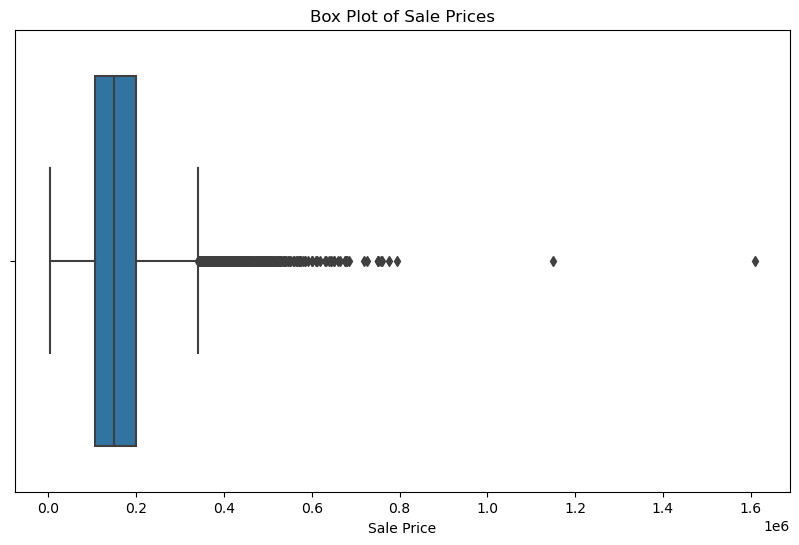

In [56]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_properties_with_dummies_df['Sale_price'])
plt.title('Box Plot of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

In [57]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = filtered_properties_with_dummies_df['Sale_price'].quantile(0.25)
Q3 = filtered_properties_with_dummies_df['Sale_price'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Calculate the lower and upper bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = filtered_properties_with_dummies_df[(filtered_properties_with_dummies_df['Sale_price'] >= 80000) & (filtered_properties_with_dummies_df['Sale_price'] <= 800000)]


# Display the DataFrame without outliers
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30383 entries, 207 to 46010
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   FinishedSqft                      30383 non-null  int32
 1   Lotsize                           30383 non-null  int32
 2   Bdrms                             30383 non-null  int32
 3   Baths_total                       30383 non-null  int32
 4   Sale_year                         30383 non-null  int32
 5   Sale_month                        30383 non-null  int32
 6   Sale_price                        30383 non-null  int32
 7   Style_AP 1                        30383 non-null  bool 
 8   Style_Bi-Level                    30383 non-null  bool 
 9   Style_Cape Cod                    30383 non-null  bool 
 10  Style_Colonial                    30383 non-null  bool 
 11  Style_Contemporary                30383 non-null  bool 
 12  Style_Cottage                     3

In [58]:
print(lower_bound)
print(upper_bound)
print(df_no_outliers.sort_values(['Sale_price']))

-35000.0
341000.0
       FinishedSqft  Lotsize  Bdrms  Baths_total  Sale_year  Sale_month  \
11627          1053     5120      2            1       2014          12   
45339          2798     5160      5            3       2023          12   
26386          1417     4500      3            1       2022           4   
31879          1640     3570      3            2       2022          10   
28512          1496     3680      5            2       2020          12   
...             ...      ...    ...          ...        ...         ...   
44502          2626     7200      4            4       2022           3   
39786          2122     6750      3            4       2023          11   
45424          2817     7500      5            4       2023           6   
42757          2389     6720      3            3       2020           7   
42788          2393     5400      4            3       2022           8   

       Sale_price  Style_AP 1  Style_Bi-Level  Style_Cape Cod  ...  \
11627      

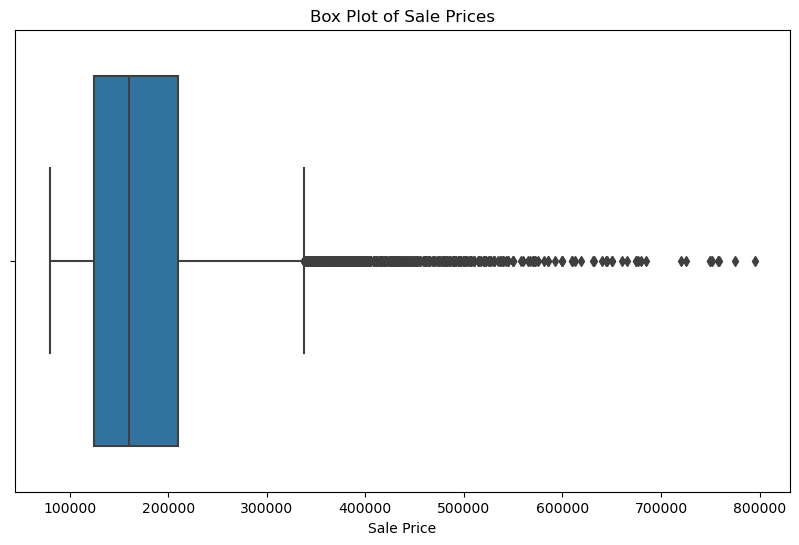

In [59]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers['Sale_price'])
plt.title('Box Plot of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

In [60]:
df_no_outliers.describe()[['Sale_price']]

,Sale_price
count,30383.000000
mean,175392.032551
std,71219.076528
min,80000.000000
25%,125000.000000
50%,160000.000000
75%,210000.000000
max,795000.000000


In [61]:
df_no_outliers.to_csv("Resources\cleaned-sales-data-with-dummies-and-no-outliers-June11.csv")